Membaca data bersih dari: preprocessed_data\cleaned_action_shelf_log.csv
Analisis Dwell Time selesai. Hasil tabel disimpan.


C:\Users\legion\AppData\Local\Temp\ipykernel_22236\366445619.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_dwell_time.index, y=avg_dwell_time.values, palette='plasma', order=avg_dwell_time.index)


Grafik Dwell Time disimpan.


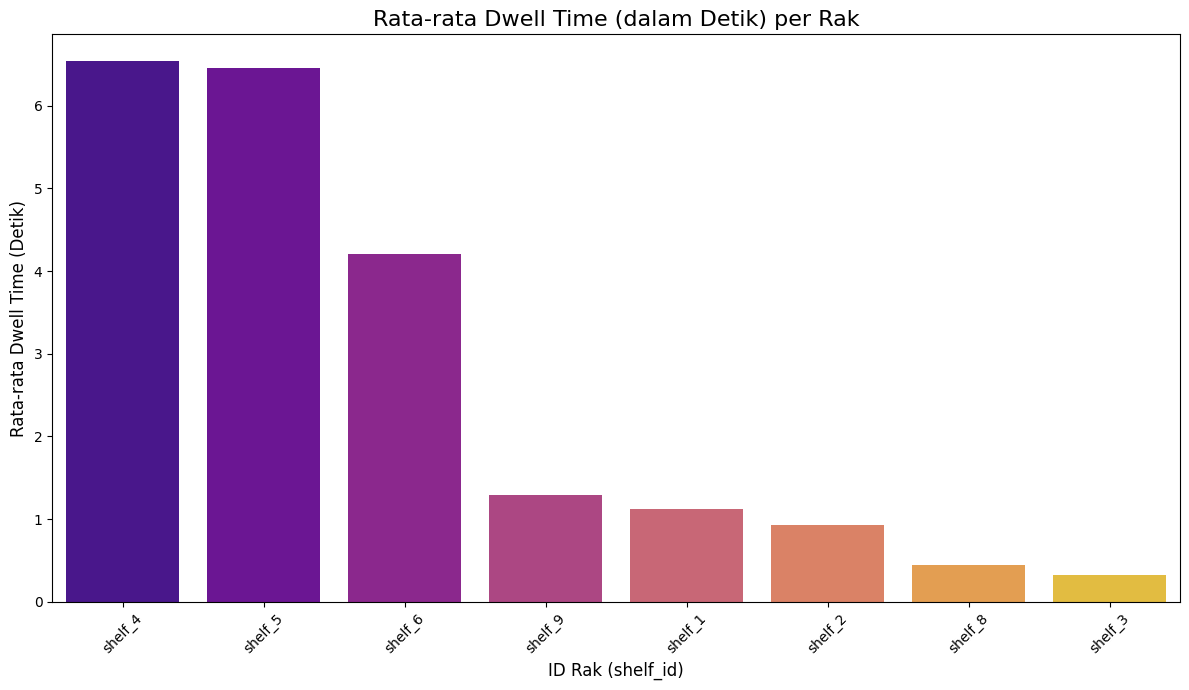


--- Memulai Analisis Funnel Keberhasilan (Reach -> Inspect) ---
Analisis Funnel Keberhasilan (Reach -> Inspect) selesai. Hasil tabel disimpan.
Grafik Funnel Keberhasilan (Reach -> Inspect) disimpan.

C:\Users\legion\AppData\Local\Temp\ipykernel_22236\366445619.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=reach_to_inspect_rates, x='shelf_id', y='conversion_rate', palette='Greens_r')


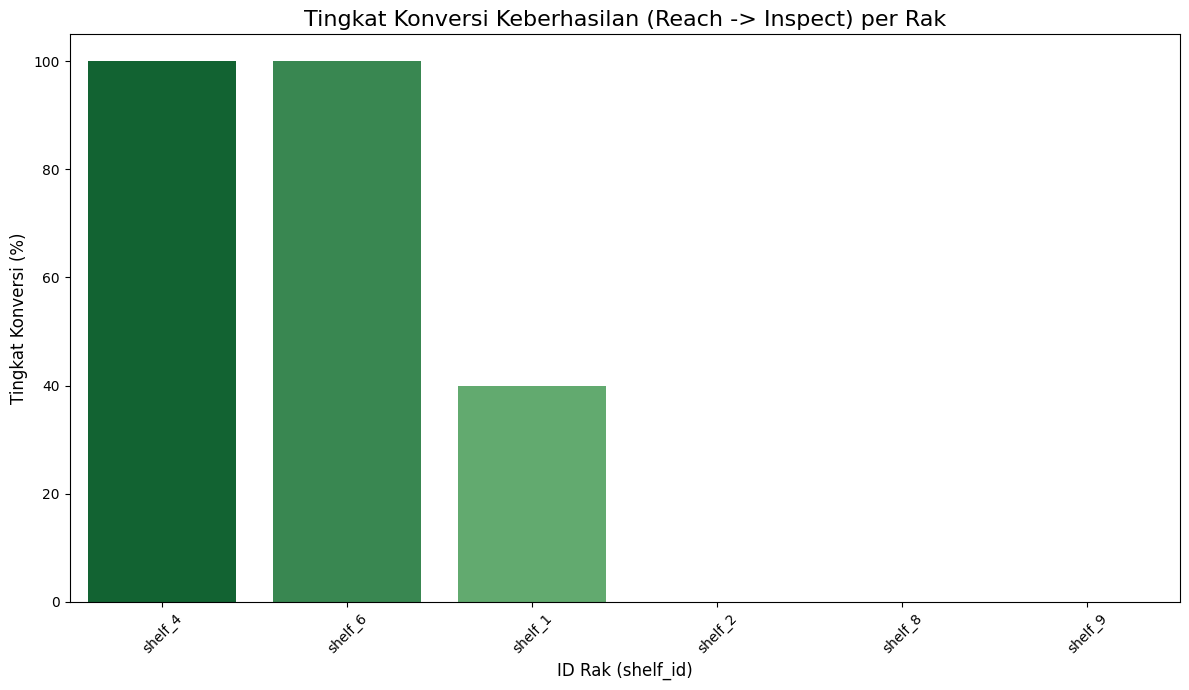


--- Memulai Analisis Funnel Keraguan (Inspect -> Hand In Shelf) ---
Analisis Funnel Keraguan (Inspect -> Hand In Shelf) selesai. Hasil tabel disimpan.
Grafik Funnel Keraguan (Inspect -> Hand In Shelf) disimpan.

C:\Users\legion\AppData\Local\Temp\ipykernel_22236\366445619.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hesitation_rates, x='shelf_id', y='hesitation_rate', palette='Reds_r')


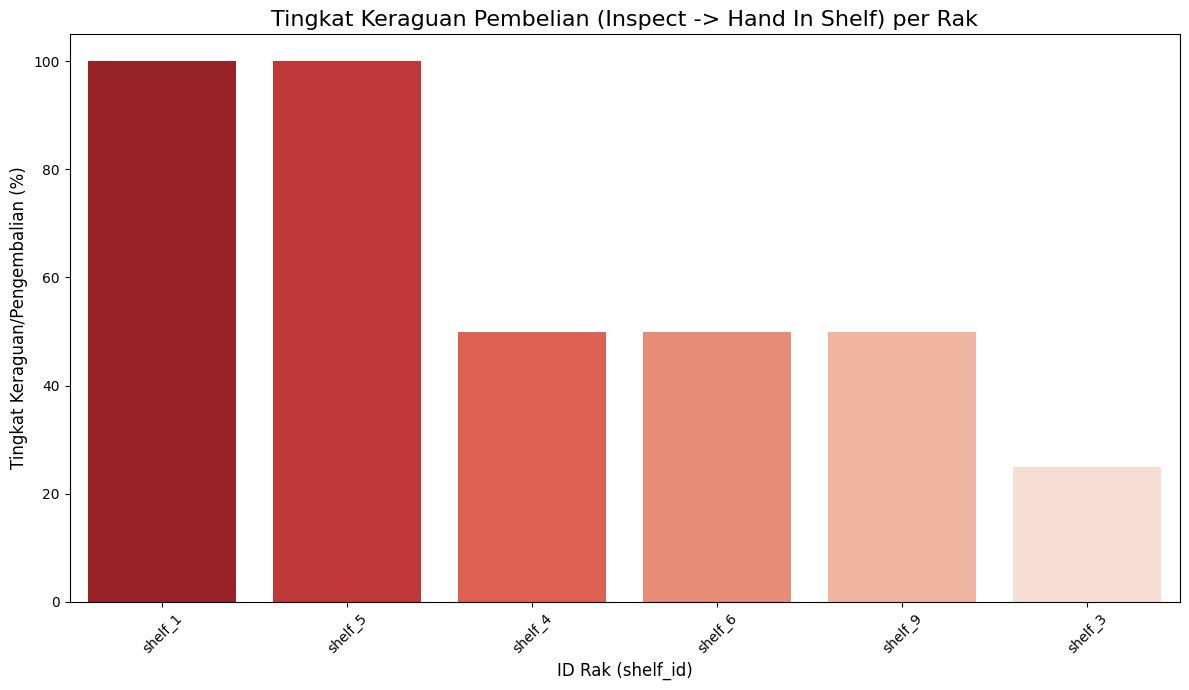


Analisis Inferensial REVISI Selesai. Hasil disimpan di folder 'inferential_outputs_revised'.


In [8]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

def inferential_analysis_revised():
    """
    Melakukan analisis inferensial dengan funnel yang telah direvisi
    berdasarkan definisi aksi yang akurat.
    """
    input_path = os.path.join('preprocessed_data', 'cleaned_action_shelf_log.csv')
    output_dir = 'inferential_outputs_revised'

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print(f"Membaca data bersih dari: {input_path}")
    try:
        df = pd.read_csv(input_path)
    except FileNotFoundError:
        print(f"Error: File tidak ditemukan di {input_path}")
        print("Jalankan script '01_preprocessing.py' terlebih dahulu.")
        return

    # --- Analisis 1: Dwell Time (Tetap Relevan) ---
    # Definisikan FPS (Frames Per Second)
    fps = 13.0

    df['next_shelf'] = df.groupby('pid')['shelf_id'].shift(-1)
    dwell_time_data = []
    for pid, group in df.groupby('pid'):
        start_frame, current_shelf = 0, -1
        for i, row in group.iterrows():
            if row['shelf_id'] != current_shelf:
                if current_shelf != -1:
                    # Hitung durasi dalam detik
                    dwell_seconds = (end_frame - start_frame) / fps
                    dwell_time_data.append({'pid': pid, 'shelf_id': current_shelf, 'dwell_time': dwell_seconds})
                current_shelf, start_frame = row['shelf_id'], row['frame']
            end_frame = row['frame']
        if current_shelf != -1:
            # Hitung durasi sesi terakhir dalam detik
            dwell_seconds = (end_frame - start_frame) / fps
            dwell_time_data.append({'pid': pid, 'shelf_id': current_shelf, 'dwell_time': dwell_seconds})
    
    dwell_df = pd.DataFrame(dwell_time_data)
    avg_dwell_time = dwell_df.groupby('shelf_id')['dwell_time'].mean().sort_values(ascending=False)
    avg_dwell_time.to_csv(os.path.join(output_dir, '1_average_dwell_time_per_shelf.csv'))
    print("Analisis Dwell Time selesai. Hasil tabel disimpan.")
    
    plt.figure(figsize=(12, 7))
    sns.barplot(x=avg_dwell_time.index, y=avg_dwell_time.values, palette='plasma', order=avg_dwell_time.index)
    # Ubah judul dan label Y-axis untuk mencerminkan unit waktu (detik)
    plt.title('Rata-rata Dwell Time (dalam Detik) per Rak', fontsize=16)
    plt.xlabel('ID Rak (shelf_id)', fontsize=12)
    plt.ylabel('Rata-rata Dwell Time (Detik)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, '1_average_dwell_time_chart.png'))
    print("Grafik Dwell Time disimpan.")
    plt.show()
    plt.close()

    # --- Analisis 2 (REVISI): Funnel "Dari Jangkauan ke Pertimbangan" (Reach -> Inspect) ---
    print("\n--- Memulai Analisis Funnel Keberhasilan (Reach -> Inspect) ---")
    
    # Pelanggan yang melakukan 'Reach To Shelf' (potensi)
    reach_events = df[df['action'] == 'Reach To Shelf'][['pid', 'shelf_id']].drop_duplicates()
    
    # Pelanggan yang melakukan 'Inspect Product' (sukses)
    inspect_events = df[df['action'] == 'Inspect Product'][['pid', 'shelf_id']].drop_duplicates()
    inspect_events['converted_to_inspect'] = True

    # Gabungkan untuk melihat berapa banyak yang 'reach' kemudian 'inspect'
    reach_to_inspect_funnel = pd.merge(reach_events, inspect_events, on=['pid', 'shelf_id'], how='left')
    reach_to_inspect_funnel['converted_to_inspect'] = reach_to_inspect_funnel['converted_to_inspect'].fillna(False)
    
    # Hitung tingkat konversi per rak
    reach_to_inspect_rates = reach_to_inspect_funnel.groupby('shelf_id').agg(
        total_reaches=('pid', 'count'),
        total_inspections=('converted_to_inspect', 'sum')
    ).reset_index()
    reach_to_inspect_rates['conversion_rate'] = (reach_to_inspect_rates['total_inspections'] / reach_to_inspect_rates['total_reaches']) * 100
    reach_to_inspect_rates = reach_to_inspect_rates.sort_values(by='conversion_rate', ascending=False)

    reach_to_inspect_rates.to_csv(os.path.join(output_dir, '2_reach_to_inspect_conversion.csv'), index=False)
    print("Analisis Funnel Keberhasilan (Reach -> Inspect) selesai. Hasil tabel disimpan.")

    plt.figure(figsize=(12, 7))
    sns.barplot(data=reach_to_inspect_rates, x='shelf_id', y='conversion_rate', palette='Greens_r')
    plt.title('Tingkat Konversi Keberhasilan (Reach -> Inspect) per Rak', fontsize=16)
    plt.xlabel('ID Rak (shelf_id)', fontsize=12)
    plt.ylabel('Tingkat Konversi (%)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, '2_reach_to_inspect_conversion_chart.png'))
    print("Grafik Funnel Keberhasilan (Reach -> Inspect) disimpan.")
    plt.show()
    plt.close()

    # --- Analisis 3 (REVISI): Funnel "Keraguan Pembelian" (Inspect -> Hand In Shelf) ---
    print("\n--- Memulai Analisis Funnel Keraguan (Inspect -> Hand In Shelf) ---")
    
    # Pelanggan yang melakukan 'Inspect Product' (potensi keraguan)
    inspect_events_for_hesitation = df[df['action'] == 'Inspect Product'][['pid', 'shelf_id']].drop_duplicates()

    # Pelanggan yang melakukan 'Hand In Shelf' (kemungkinan mengembalikan produk)
    hand_in_shelf_events = df[df['action'] == 'Hand In Shelf'][['pid', 'shelf_id']].drop_duplicates()
    hand_in_shelf_events['returned_product'] = True

    # Gabungkan untuk melihat berapa banyak yang 'inspect' kemudian 'hand in shelf'
    hesitation_funnel = pd.merge(inspect_events_for_hesitation, hand_in_shelf_events, on=['pid', 'shelf_id'], how='left')
    hesitation_funnel['returned_product'] = hesitation_funnel['returned_product'].fillna(False)

    # Hitung tingkat "pengembalian" per rak
    hesitation_rates = hesitation_funnel.groupby('shelf_id').agg(
        total_inspections=('pid', 'count'),
        total_returns=('returned_product', 'sum')
    ).reset_index()
    hesitation_rates['hesitation_rate'] = (hesitation_rates['total_returns'] / hesitation_rates['total_inspections']) * 100
    hesitation_rates = hesitation_rates.sort_values(by='hesitation_rate', ascending=False)

    hesitation_rates.to_csv(os.path.join(output_dir, '3_inspect_to_return_hesitation.csv'), index=False)
    print("Analisis Funnel Keraguan (Inspect -> Hand In Shelf) selesai. Hasil tabel disimpan.")

    plt.figure(figsize=(12, 7))
    sns.barplot(data=hesitation_rates, x='shelf_id', y='hesitation_rate', palette='Reds_r')
    plt.title('Tingkat Keraguan Pembelian (Inspect -> Hand In Shelf) per Rak', fontsize=16)
    plt.xlabel('ID Rak (shelf_id)', fontsize=12)
    plt.ylabel('Tingkat Keraguan/Pengembalian (%)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, '3_inspect_to_return_hesitation_chart.png'))
    print("Grafik Funnel Keraguan (Inspect -> Hand In Shelf) disimpan.")
    plt.show()
    plt.close()

    print(f"\nAnalisis Inferensial REVISI Selesai. Hasil disimpan di folder '{output_dir}'.")

if __name__ == '__main__':
    inferential_analysis_revised()